<a href="https://colab.research.google.com/github/udlbook/udlbook/blob/main/Notebooks/Chap11/11_2_Residual_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 11.2: Residual Networks**

This notebook adapts the networks for MNIST1D to use residual connections.

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.



In [192]:
# Run this if you're in a Colab to install MNIST 1D repository
%pip install git+https://github.com/greydanus/mnist1d

  Cloning https://github.com/greydanus/mnist1d to c:\users\pisit_pisuttipunpong\appdata\local\temp\pip-req-build-o49x2k23
  Resolved https://github.com/greydanus/mnist1d to commit 7878d96082abd200c546a07a4101fa90b30fdf7e
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d 'C:\Users\pisit_pisuttipunpong\AppData\Local\Temp\pip-req-build-o49x2k23'

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [193]:
import numpy as np
import os
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import torch.nn.functional as F
import mnist1d
import random

In [194]:
args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=False, regenerate=False)

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

Successfully loaded data from ./mnist1d_data.pkl
Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40


In [195]:
# Load in the data
train_data_x = data['x'].transpose()
train_data_y = data['y']
val_data_x = data['x_test'].transpose()
val_data_y = data['y_test']
# Print out sizes
print("Train data: %d examples (columns), each of which has %d dimensions (rows)"%((train_data_x.shape[1],train_data_x.shape[0])))
print("Validation data: %d examples (columns), each of which has %d dimensions (rows)"%((val_data_x.shape[1],val_data_x.shape[0])))

Train data: 4000 examples (columns), each of which has 40 dimensions (rows)
Validation data: 1000 examples (columns), each of which has 40 dimensions (rows)


Define the network

In [196]:
# There are 40 input dimensions and 10 output dimensions for this data
# The inputs correspond to the 40 offsets in the MNIST1D template.
D_i = 40
# The outputs correspond to the 10 digits
D_o = 10


# We will adapt this model to have residual connections around the linear layers
# This is the same model we used in practical 8.1, but we can't use the sequential
# class for residual networks (which aren't strictly sequential).  Hence, I've rewritten
# it as a model that inherits from a base class

class ResidualNetwork(torch.nn.Module):
  def __init__(self, input_size, output_size, enable_resnet=True, hidden_size=100):
    super(ResidualNetwork, self).__init__()
    self.linear1 = nn.Linear(input_size, hidden_size)
    self.linear2 = nn.Linear(hidden_size, hidden_size)
    self.linear3 = nn.Linear(hidden_size, hidden_size)
    self.linear4 = nn.Linear(hidden_size, output_size)
    self.enable_resnet = enable_resnet
    print("Initialized MLPBase model with {} parameters".format(self.count_params()))

  def count_params(self):
    return sum([p.view(-1).shape[0] for p in self.parameters()])

# TODO -- Add residual connections to this model
# The order of operations within each block should similar to figure 11.5b
# ie., linear1 first, ReLU+linear2 in first residual block, ReLU+linear3 in second residual block), linear4 at end
# Replace this function
  def forward(self, x):
    h1 = self.linear1(x).relu()
    residual1 = self.linear2(h1)
    if(self.enable_resnet):
      h2 = self.linear2(residual1.relu()) + residual1
      h3 = self.linear3(self.linear3(h2.relu()).relu()) + h2
    else:
      h2 = self.linear2(residual1.relu())
      h3 = self.linear3(self.linear3(h2.relu()).relu())
    return self.linear4(h3)


In [197]:
# He initialization of weights
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

In [198]:
# Define the models
model_with_resnet = ResidualNetwork(40, 10, enable_resnet=True)
model_without_resnet = ResidualNetwork(40, 10, enable_resnet=False)

# Define separate loss functions and optimizers
loss_function = nn.CrossEntropyLoss()

# Optimizer and scheduler for model with resnet
optimizer_with_resnet = torch.optim.SGD(model_with_resnet.parameters(), lr=0.05, momentum=0.9)
scheduler_with_resnet = StepLR(optimizer_with_resnet, step_size=20, gamma=0.5)

# Optimizer and scheduler for model without resnet
optimizer_without_resnet = torch.optim.SGD(model_without_resnet.parameters(), lr=0.05, momentum=0.9)
scheduler_without_resnet = StepLR(optimizer_without_resnet, step_size=20, gamma=0.5)

# Convert data to torch tensors
x_train = torch.tensor(train_data_x.transpose().astype('float32'))
y_train = torch.tensor(train_data_y.astype('long')).long()
x_val = torch.tensor(val_data_x.transpose().astype('float32'))
y_val = torch.tensor(val_data_y.astype('long')).long()

# Load data into DataLoader
data_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=100, shuffle=True, worker_init_fn=random.seed(0))

# Initialize weights for both models
model_with_resnet.apply(weights_init)
model_without_resnet.apply(weights_init)

# Store the statistics for both models
n_epoch = 100
losses_train_with_resnet = np.zeros((n_epoch))
errors_train_with_resnet = np.zeros((n_epoch))
losses_val_with_resnet = np.zeros((n_epoch))
errors_val_with_resnet = np.zeros((n_epoch))

losses_train_without_resnet = np.zeros((n_epoch))
errors_train_without_resnet = np.zeros((n_epoch))
losses_val_without_resnet = np.zeros((n_epoch))
errors_val_without_resnet = np.zeros((n_epoch))

# Function to train a model and return losses and errors
def train_model(model, optimizer, scheduler, losses_train, errors_train, losses_val, errors_val):
    for epoch in range(n_epoch):
        # Training loop over batches
        for i, data in enumerate(data_loader):
            x_batch, y_batch = data
            optimizer.zero_grad()
            pred = model(x_batch)
            loss = loss_function(pred, y_batch)
            loss.backward()
            optimizer.step()

        # Collect statistics
        pred_train = model(x_train)
        pred_val = model(x_val)
        _, predicted_train_class = torch.max(pred_train.data, 1)
        _, predicted_val_class = torch.max(pred_val.data, 1)
        
        errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
        errors_val[epoch] = 100 - 100 * (predicted_val_class == y_val).float().sum() / len(y_val)
        losses_train[epoch] = loss_function(pred_train, y_train).item()
        losses_val[epoch] = loss_function(pred_val, y_val).item()

        print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  val loss {losses_val[epoch]:.6f}, percent error {errors_val[epoch]:3.2f}')
        
        scheduler.step()

# Train the model without residual connections
print("Training without residual connections...")
train_model(model_without_resnet, optimizer_without_resnet, scheduler_without_resnet, 
            losses_train_without_resnet, errors_train_without_resnet, losses_val_without_resnet, errors_val_without_resnet)

# Train the model with residual connections
print("Training with residual connections...")
train_model(model_with_resnet, optimizer_with_resnet, scheduler_with_resnet, 
            losses_train_with_resnet, errors_train_with_resnet, losses_val_with_resnet, errors_val_with_resnet)

Initialized MLPBase model with 25310 parameters
Initialized MLPBase model with 25310 parameters
Training without residual connections...
Epoch     0, train loss 1.649799, train error 64.80,  val loss 1.702830, percent error 68.20
Epoch     1, train loss 1.505230, train error 60.15,  val loss 1.605332, percent error 63.40
Epoch     2, train loss 1.169609, train error 44.08,  val loss 1.305980, percent error 52.90
Epoch     3, train loss 1.066181, train error 41.17,  val loss 1.340376, percent error 52.20
Epoch     4, train loss 0.971143, train error 37.38,  val loss 1.251654, percent error 50.70
Epoch     5, train loss 0.900172, train error 35.97,  val loss 1.227814, percent error 48.80
Epoch     6, train loss 0.764757, train error 28.88,  val loss 1.182428, percent error 45.10
Epoch     7, train loss 0.734133, train error 27.95,  val loss 1.150005, percent error 43.80
Epoch     8, train loss 0.769933, train error 29.32,  val loss 1.378353, percent error 48.70
Epoch     9, train loss 0.

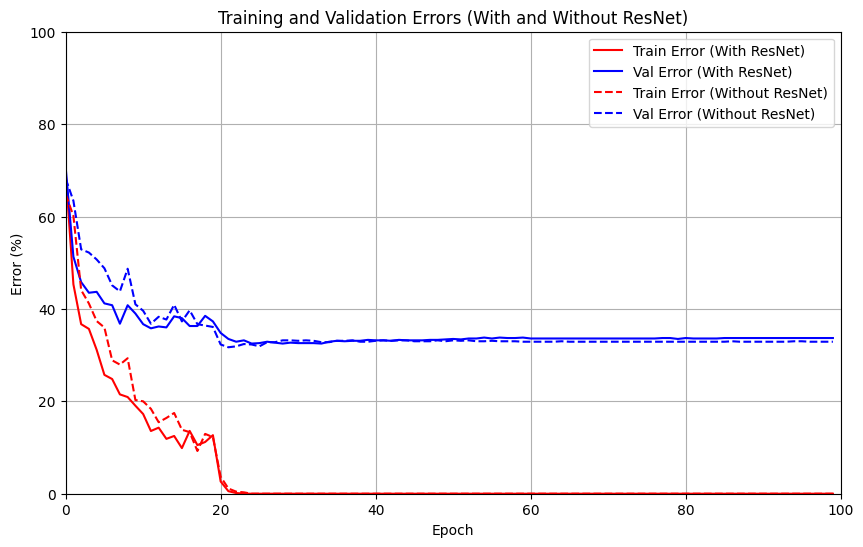

In [199]:
def plot_eval(errors_train_with_resnet, errors_val_with_resnet, 
                errors_train_without_resnet, errors_val_without_resnet, n_epoch):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot training and validation errors for the model with residual connections
    ax.plot(errors_train_with_resnet, 'r-', label='Train Error (With ResNet)')
    ax.plot(errors_val_with_resnet, 'b-', label='Val Error (With ResNet)')

    # Plot training and validation errors for the model without residual connections
    ax.plot(errors_train_without_resnet, 'r--', label='Train Error (Without ResNet)')
    ax.plot(errors_val_without_resnet, 'b--', label='Val Error (Without ResNet)')

    ax.set_ylim(0, 100)
    ax.set_xlim(0, n_epoch)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Error (%)')
    ax.set_title('Training and Validation Errors (With and Without ResNet)')
    ax.legend()

    plt.grid(True)
    plt.show()

# Plot the errors
plot_eval(errors_train_with_resnet, errors_val_with_resnet, 
            errors_train_without_resnet, errors_val_without_resnet, n_epoch)

The primary motivation of residual networks is to allow training of much deeper networks.   

TODO: Try running this network with and without the residual connections.  Does adding the residual connections change the performance?

# 640615023 Pisit Pisuttipunpong

Question: Does adding the residual connections change the performance?

Answer: Yes, based on the Training and Validation Errors (With and Without ResNet) it show that using ResNet improve the performance for both Training and Validation Error by decreasing error of the model